# Método Montecarlo, basado en ideas de: 

## Método Montecarlo de I.M. Sobol, editorial Mir

In [4]:
import numpy as np
from __future__ import division
from IPython.display import Math
import matplotlib.pyplot as mpl

%load_ext Cython


In [19]:
Math(r'A = \int_{0}^{1} (1 - x ^ 2) dx')

<IPython.core.display.Math object>

In [20]:
# Cantidad de puntos usados en la integración
N=1000000

# Cálculo de la solución analítica de la integral 
A = np.pi/4

# Solución numérica regla de Simpson
x=np.arange(0,1,1/N)
y = np.sqrt(1 - x*x)
An = np.sum(y)/N

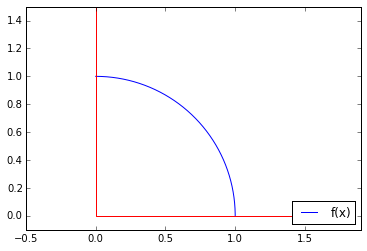

In [21]:
%matplotlib inline
# change axis range for x and y
mpl.xlim([-0.1,1.5])
mpl.ylim([-0.1,1.5])
mpl.axes().set_aspect('equal', 'datalim')
mpl.plot(x,y, label='f(x)' ); mpl.legend(loc='lower right');
mpl.plot([0, 0,1.5], [1.50, 0,0], 'red');


In [22]:
# Integración Montecarlo de 1/4 de círculo
# Generación de los pares (x,y) aleatorios
x,y=(np.random.rand(N),np.random.rand(N))

z=x*x+y*y

#Enmascara si es más grande que 1
z=z[z<=1]

#Determina el tamaño del array resultante
Np = z.size
# Cálcula el área
Am = Np/N


print(A, Am, An)

0.7853981633974483 0.785709 0.785398663103


In [17]:
N = 1000000
Ss = 0.01 
Sc = 0.1 
S = Ss + Sc
CLM = 1/S
#Espesor de la placa
espH = 1
global Npas, Nref, Nabs

In [18]:
def neutron_placa (Ss, Sc, espH):
    global Npas, Nref, Nabs
    
    x = 0
    gmm  = .5
    S = Ss + Sc
    
    while (True):
        u = 2 * gmm - 1
        lmbd = -1 * np.log(np.random.random()) / S
        x = (x  + lmbd * u)
        if x > espH:
            Npas = Npas + 1; break;
        else:
            if x < 0:
                Nref = Nref + 1; break;
            else:
                sc = np.random.random()
                if sc < Sc/S:
                    Nabs = Nabs + 1; break
                else:
                    gmm  = np.random.random()
                    #u = 2*gmm - 1
  
if __name__ == "__main__":
    Npas = Nref = Nabs = 0;
    for j in range (0,N):
        neutron_placa (Ss, Sc, espH)

    print(Npas/N, Nref/N, Nabs/N, (Npas+ Nref+ Nabs)/N)

0.03249 0.045902 0.921608 1.0


In [10]:
%%cython

cimport cython

from libc.stdlib cimport rand, srand
from libc.time cimport time, time_t
from libc.math cimport  log

cdef extern from "stdlib.h":
  cdef int RAND_MAX

@cython.cdivision(True)
def init_rand ():    
   cdef time_t seconds  
   time(&seconds)
   srand(<unsigned int>seconds)

@cython.cdivision(True)
def neutron_placa_c (float Ss, float Sc, float espH ):
    cdef int Npas = 0
    cdef int Nref = 0
    cdef int Nabs = 0
        
    cdef float u, x=0, gmm  = 1, sc, S
    
    S = Ss + Sc
     
    while (True):
        u = 2 * gmm - 1
        lmbd = -1 * log(gmm) / S
        x = (x  + lmbd*u)
        if x > espH:
            Npas = Npas + 1; break;
        else:
            if x < 0:
                Nref = Nref + 1; break;
            else:
                sc = <float>rand()/<float>RAND_MAX
               
                if sc < Sc/S:
                    Nabs = Nabs + 1; break;
                else:
                    gmm  = <float>rand()/<float>RAND_MAX
                   
    return Npas, Nref, Nabs

## Uso de la función definida con cython

In [11]:
if __name__ == "__main__":

    global Npas, Nref, Nabs, np
    N = 10000
    espH = 1
    Ss = 0.01
    Sc = 0.1
    S = Ss + Sc
    Npas = Nref = Nabs = 0;

    for j in range (0,N):
      (pas, ref, abs_ ) = neutron_placa_c(Ss, Sc, espH)
      Npas +=pas; Nref += ref; Nabs += abs_
        
    maxs =[Npas/N, Nref/N, Nabs/N]
    print(maxs)
    
    #print(neutron_placa_c(Ss, Sc, espH))

[0.0221, 0.0516, 0.9263]


## Vectorización

In [41]:
from __future__ import division
import numpy as np

Sc = 0.1
Ss = 0.01
S = Ss + Sc

N = 10000
h = 1

def info_p(orig, Natr, Nref, Ncap, Total):
    print("Orig: %s Natr: %d Nref: %d Ncap: %d Totales: %d" % (orig, Natr, Nref, Ncap, Total))
    print(" \t Patr: %f Pref: %f Pcap: %f\n" % (Natr/Total, Nref/Total, Ncap/Total))

def func(N):
    Natr = 0
    Nref = 0
    Ncap = 0

    #
    # posicion incial
    #
    deltaX = np.zeros(N)

    while N > 0:

        dir = 2 * np.random.random(N) - 1
        recorr = - np.log(np.random.random(N)) / S

        deltaX = deltaX + dir * recorr

        Natr = Natr + (deltaX > h).sum()
        Nref = Nref + (deltaX < 0).sum()
 
        dentro = np.copy(deltaX[np.logical_and(deltaX>=0, deltaX<=h)])

        sorteoCaptura = np.random.random(dentro.size)
    
        capturados = sorteoCaptura < Sc / S
        
        no_capturados = sorteoCaptura >= Sc/S
        print(no_capturados.sum(), no_capturados.size)
        
        Ncap = Ncap + capturados.sum()
        
        
        siguen     = np.copy(dentro[no_capturados])
         
        
        N = siguen.size

        deltaX = siguen
        
    Total =  Natr + Nref + Ncap + N
    info_p("parc", Natr, Nref, Ncap, Total)
    return (Natr, Nref, Ncap)

if __name__ == "__main__":
    func(N)


112 1422
1 20
0 0
Orig: parc Natr: 3637 Nref: 5034 Ncap: 1329 Totales: 10000
 	 Patr: 0.363700 Pref: 0.503400 Pcap: 0.132900

